In [1]:
from braket.aws import AwsQuantumJob, AwsSession
from braket.jobs.local import LocalQuantumJob
from braket.jobs.image_uris import Framework, retrieve_image
import time
import pickle

aws_session = AwsSession(default_bucket="amazon-braket-eu-west-2-lukasvoss")

In [2]:
# "arn:aws:braket:eu-west-2::device/qpu/oqc/Lucy"

device = "arn:aws:braket:eu-west-2::device/qpu/oqc/Lucy" # "arn:aws:braket:::device/quantum-simulator/amazon/sv1"

parts = device.split('/')
# Access the last element
device_name = parts[-1]

In [3]:
num_total_updates = 125

hyperparams = {
    "num_total_updates": num_total_updates, 
}

#Name your job so that it can be later identified
job_name = f'cx-gate-calibration-{num_total_updates}-updates-{str(int(time.time()))}-{device_name}'

# Specify one of the ready-to-use containers provided by Amazon Braket
# image_uri = retrieve_image(Framework.PL_PYTORCH, AwsSession().region)

q_env_config_path = 'config_yamls/q_env_gate_config.yaml'
agent_config_path = 'config_yamls/agent_config.yaml'

input_config = {
    'q-env-config': q_env_config_path,
    'agent-config': agent_config_path,
}

In [4]:
job = AwsQuantumJob.create(
    #Run this hybrid job on the SV1 simulator
    device=device,
    #The directory or single file containing the code to run.
    source_module="needed_files",
    #The main script or function the job will run.
    entry_point="needed_files.algorithm_script:calibrate_gate",
    #Set the name of the job
    job_name=job_name,
    # Set the hyperparameters
    hyperparameters=hyperparams,
    # Specify the image to use for the container to run the script in
    # image_uri=image_uri,
    # Define the file that contains the input data but not relevant for the minimal example
    input_data=input_config,
    wait_until_complete=True,
    aws_session=aws_session,
)

Initializing Braket Job: arn:aws:braket:eu-west-2:229406906664:job/cx-gate-calibration-125-updates-1706696552-Lucy
......................
2024-01-31 10:24:48,523 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-01-31 10:24:48,524 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2024-01-31 10:24:48,537 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-01-31 10:24:48,538 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2024-01-31 10:24:48,549 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-01-31 10:24:48,549 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2024-01-31 10:24:48,560 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "agent-config": "/opt/ml/i

In [5]:
while job.state() not in job.TERMINAL_STATES:
    print(job.state())
    time.sleep(30)

print(job.state())
print(job.result())

COMPLETED
{'avg_reward': [0.35598672215918337, 0.36010754323874955, 0.22963266748657596, 0.2589731547395309, 0.35173161652770446, 0.25376994369618, 0.2983915807112539, 0.26838158786513505, 0.38135103622948124, 0.49597216922044673, 0.46077262341100517, 0.4366428383234903, 0.2799732662087706, 0.24736864435871045, 0.5172759741944899, 0.499814889122538, 0.3832143003546754, 0.4567837582191679, 0.26793081414879427, 0.25543948021963175, 0.5785362343358885, 0.4762471649498793, 0.6215236116634657, 0.736592301322276, 0.24979851833712963, 0.36383160371786755, 0.25956007283141863, 0.7246194408166927, 0.5382547061311738, 0.3407650873072253, 0.2439181641890428, 0.5273939659421581, 0.5056714841732707, 0.40031641347939395, 0.7600249593185839, 0.8050525056323977, 0.8635609417440582, 0.2800021305391957, 0.3027060401042721, 0.6175938186422516, 0.6871076263396914, 0.3256511588022611, 0.877713666650408, 0.35467048409128366, 0.5511028101197832, 0.8511594497787763, 0.8405103408246373, 0.8548789205999823, 0.3

In [6]:
with open(job_name, 'wb') as handle:
    pickle.dump(job.result(), handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
avg_reward = job.result()['avg_reward']
std_actions = job.result()['std_actions']
fidelities = job.result()['fidelities']

#### Visualize results

In [8]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [9]:
# plt.plot(np.arange(1, len(avg_reward)+1), avg_reward, label='mean reward')
# plt.plot(np.arange(2, len(fidelities)+2), fidelities, label='gate fidelity')
# plt.xlabel('update step')
# plt.legend()

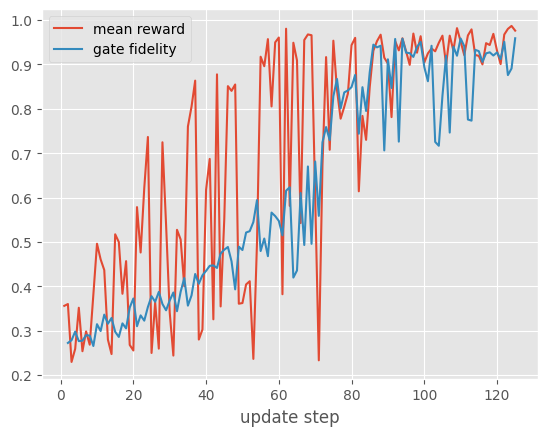

In [10]:
plt.plot(np.arange(1, num_total_updates+1), avg_reward, label='mean reward')
plt.plot(np.arange(2, num_total_updates+1), fidelities, label='gate fidelity')
plt.xlabel('update step')
plt.legend()

In [11]:
print(f'Final Gate Fidelity: {fidelities[-1]:.4%}')
print(f'\nMax Gate Fidelity: {max(fidelities):.4%}')

Final Gate Fidelity: 95.9071%

Max Gate Fidelity: 95.9071%


In [12]:
std_actions_componentwise = list(zip(*std_actions))

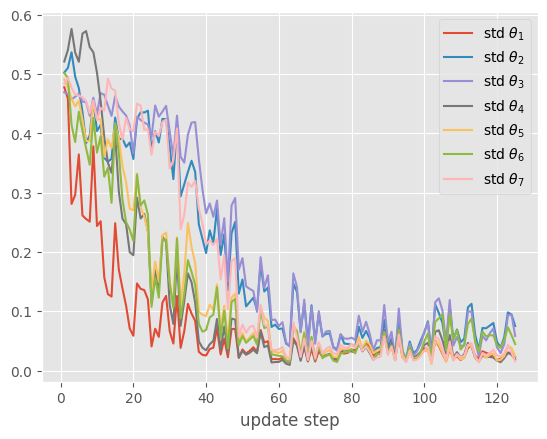

In [13]:
for ind, param in enumerate(std_actions_componentwise):
    plt.plot(np.arange(1, num_total_updates+1), param, label=r'std $\theta_{}$'.format(ind+1))

plt.xlabel('update step')
plt.legend()

#### Best Action Vector

In [14]:
best_action_vector = job.result()['action_vector']

In [15]:
best_action_vector

[0.08889250457286835,
 0.09199437499046326,
 -1.3541978597640991,
 -1.312541127204895,
 -1.5377848148345947,
 1.2155877351760864,
 1.2591086626052856]